In [3]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
from get_utils import get_hidden, get_force, get_data
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
import pandas as pd
from tdr import gsog

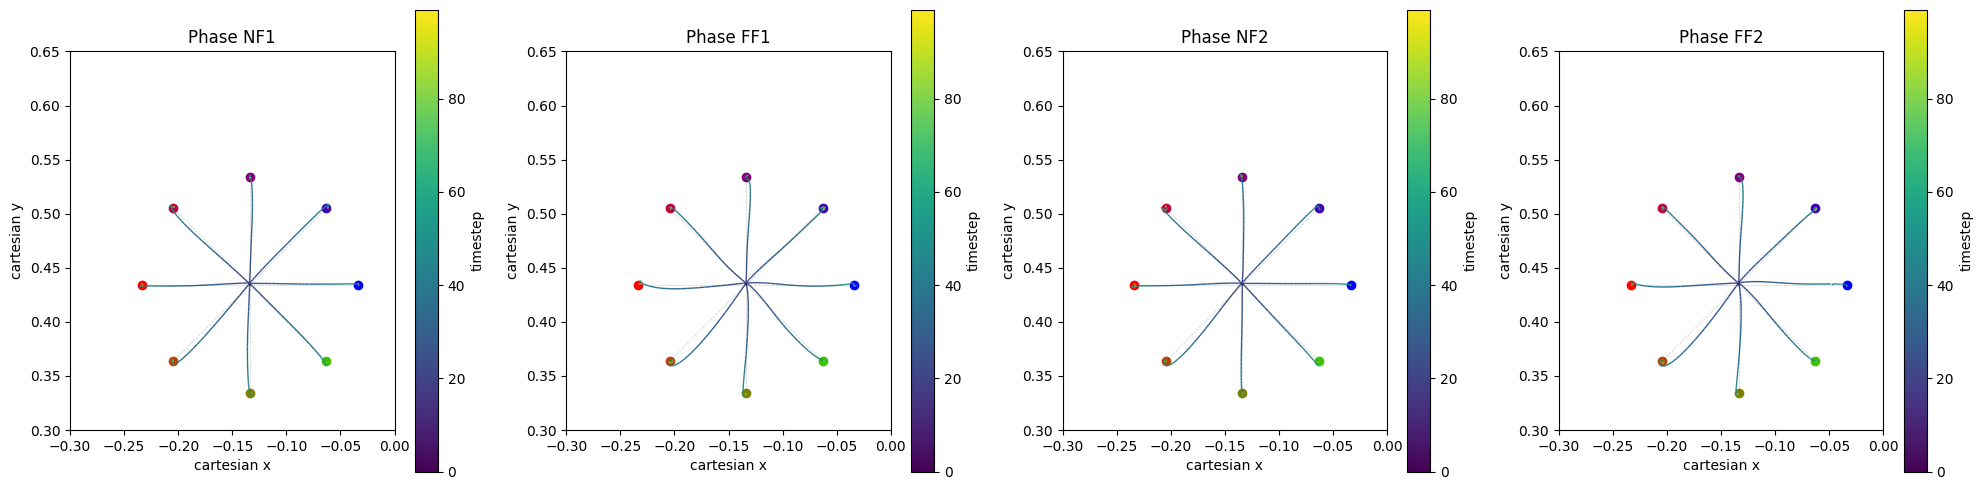

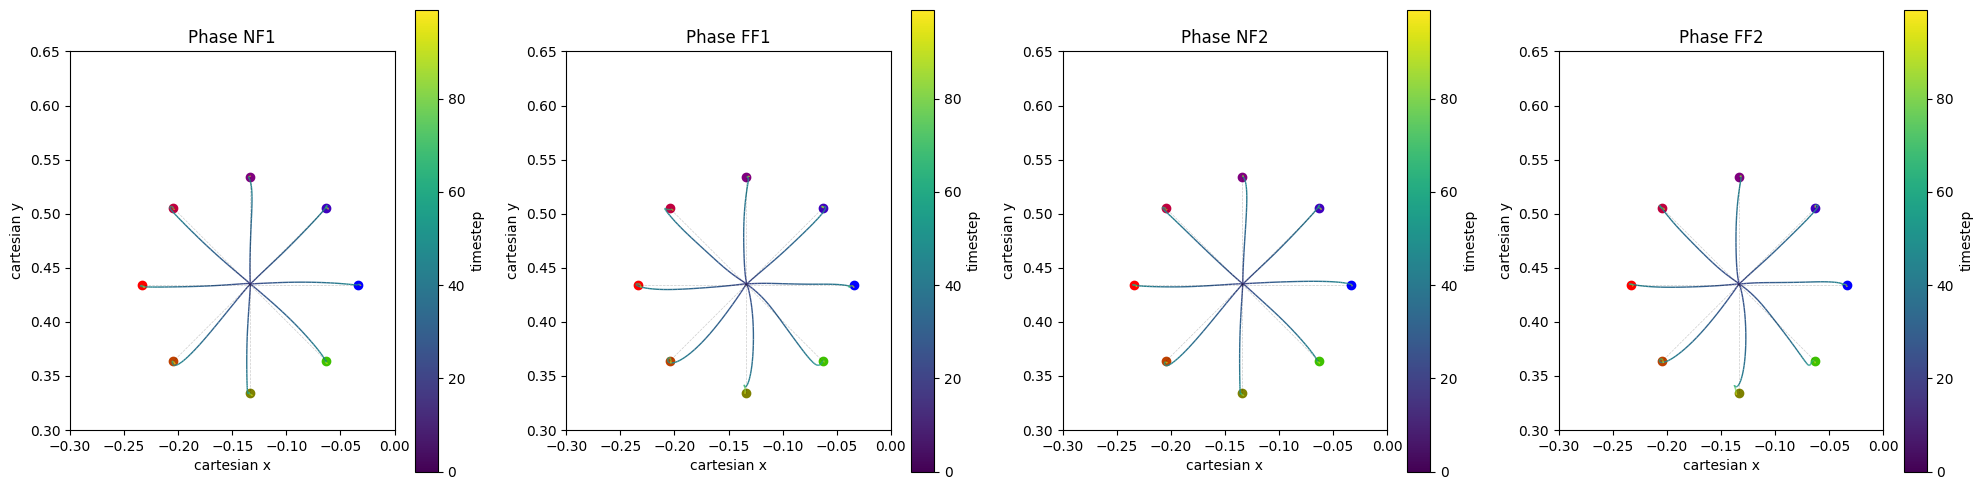

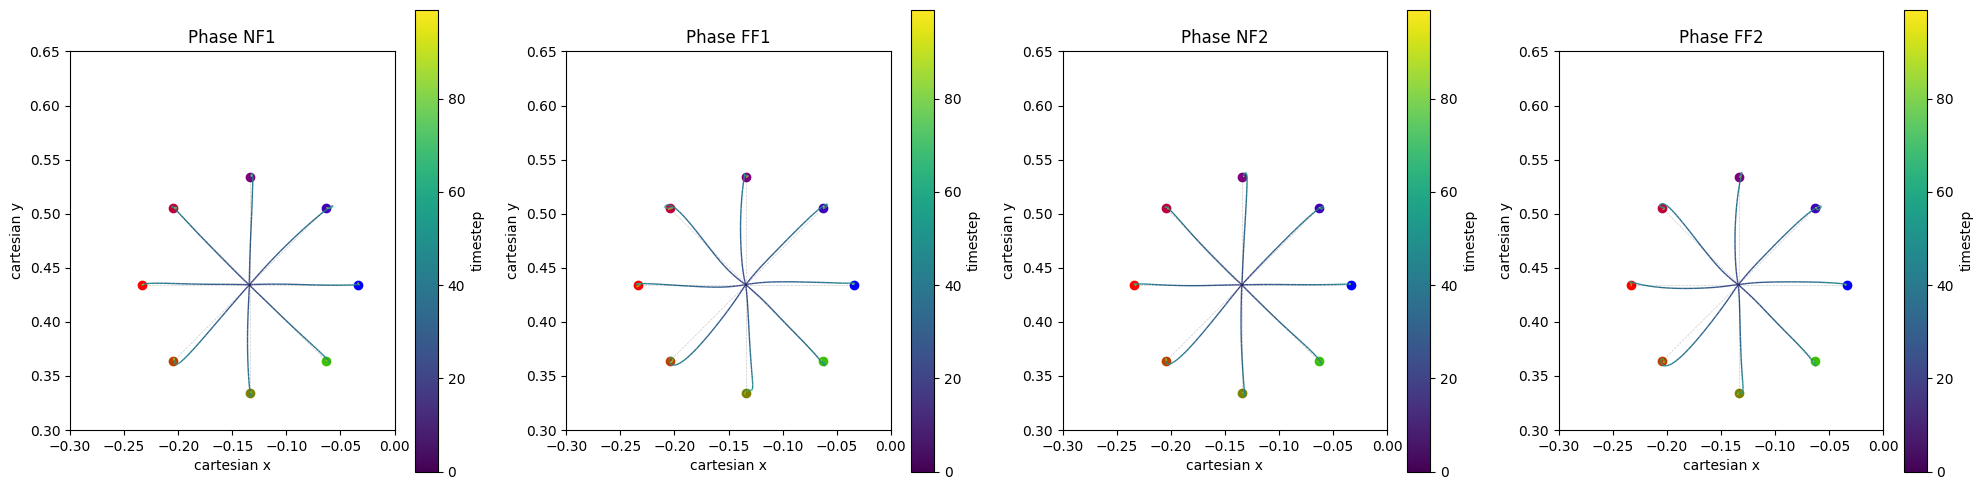

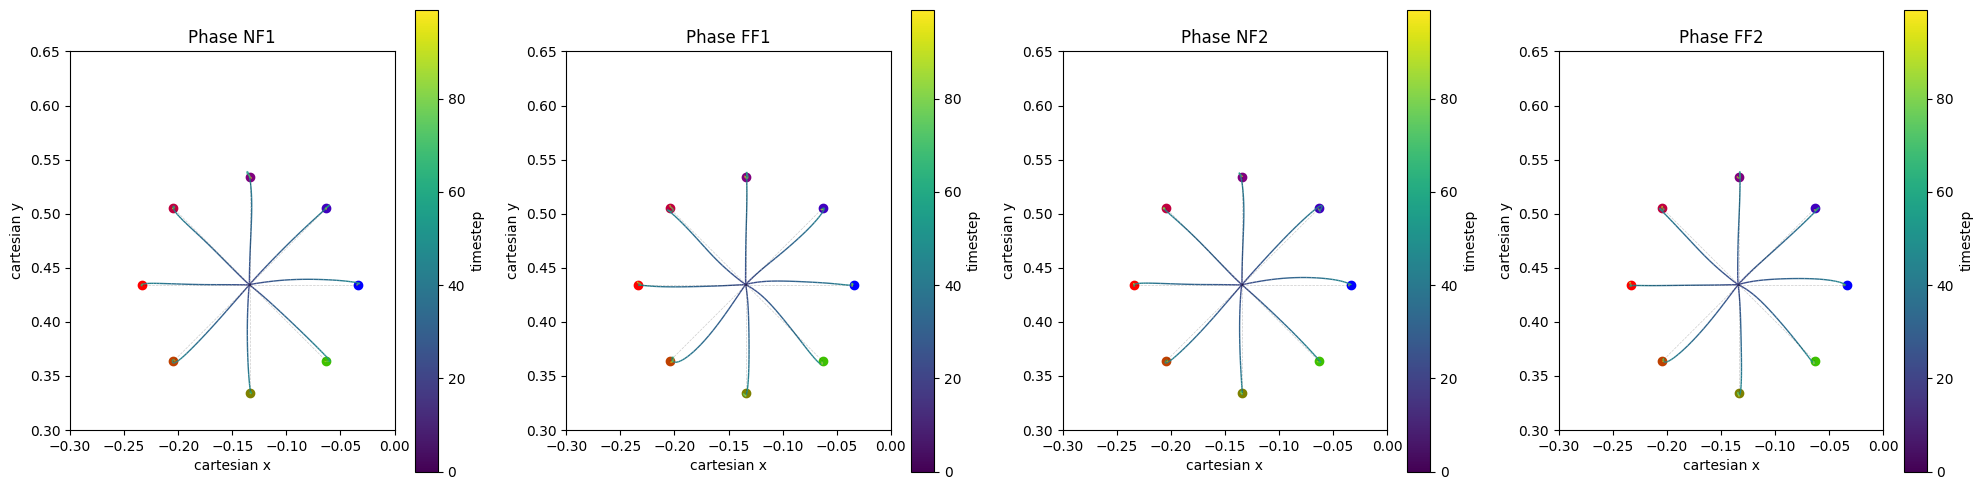

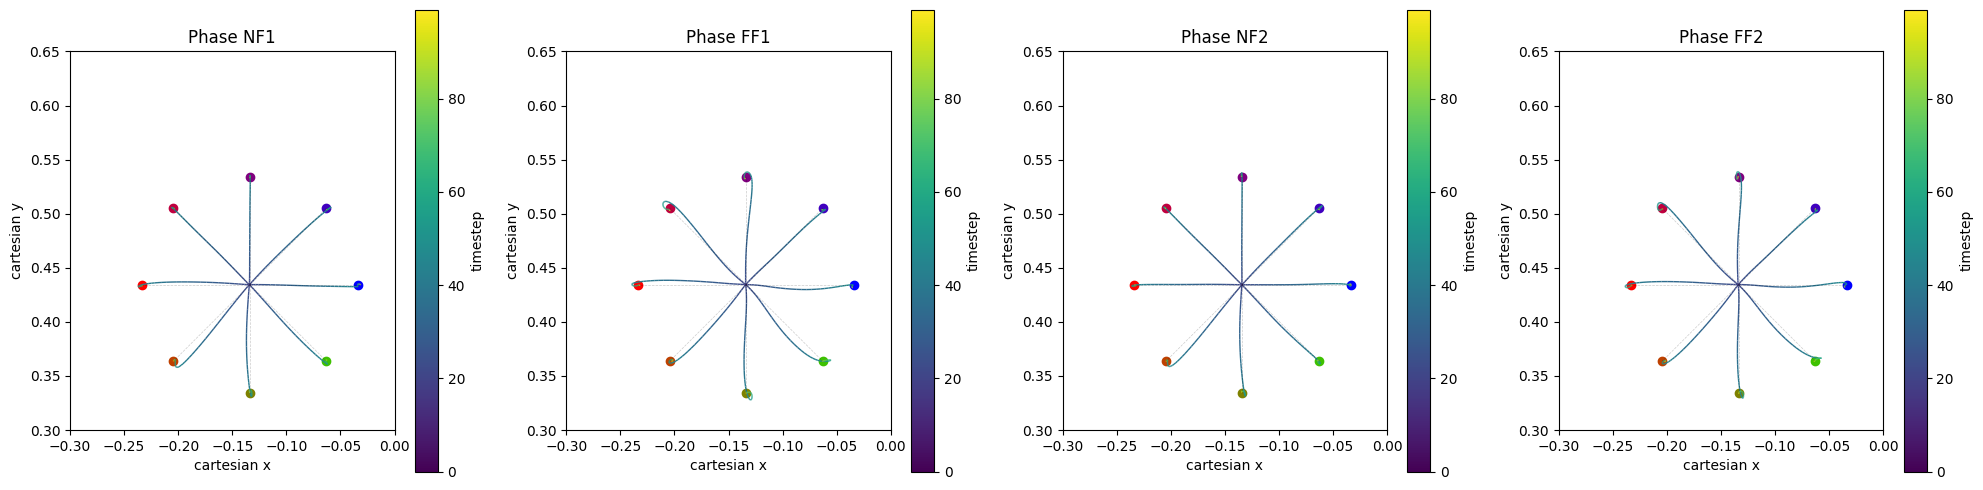

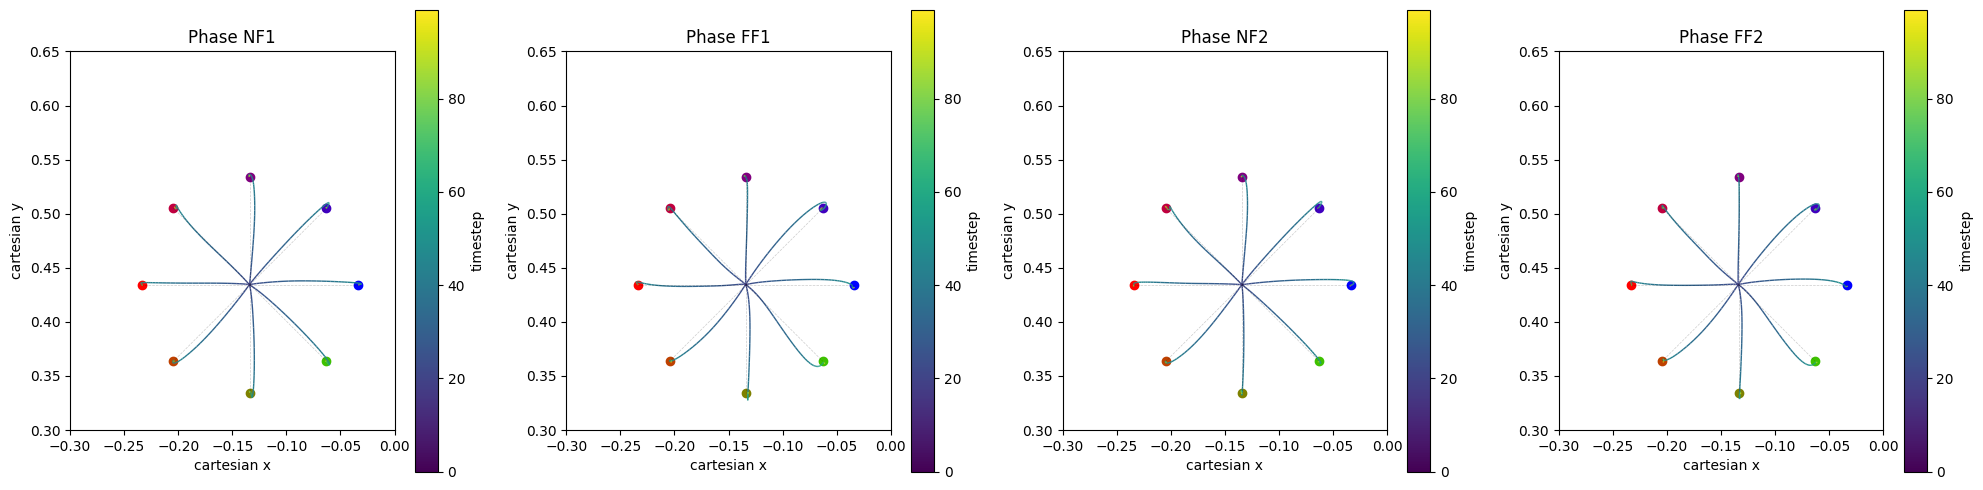

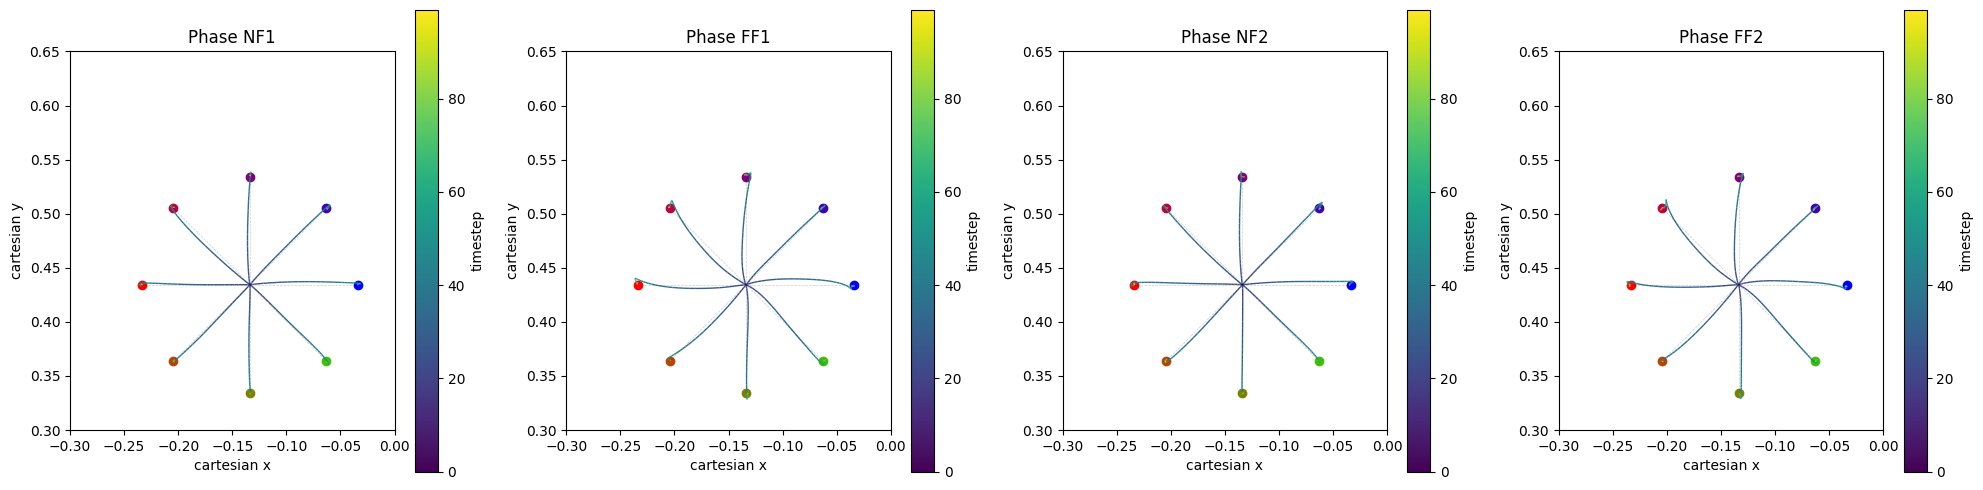

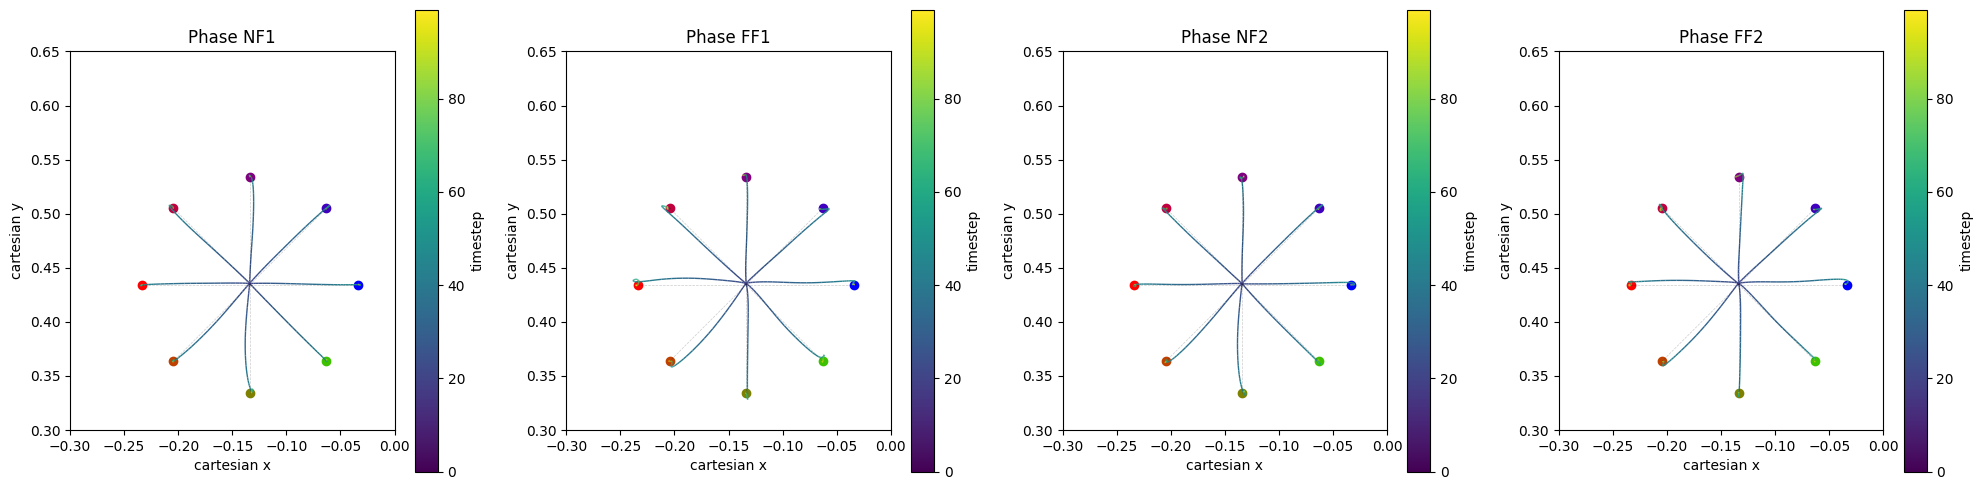

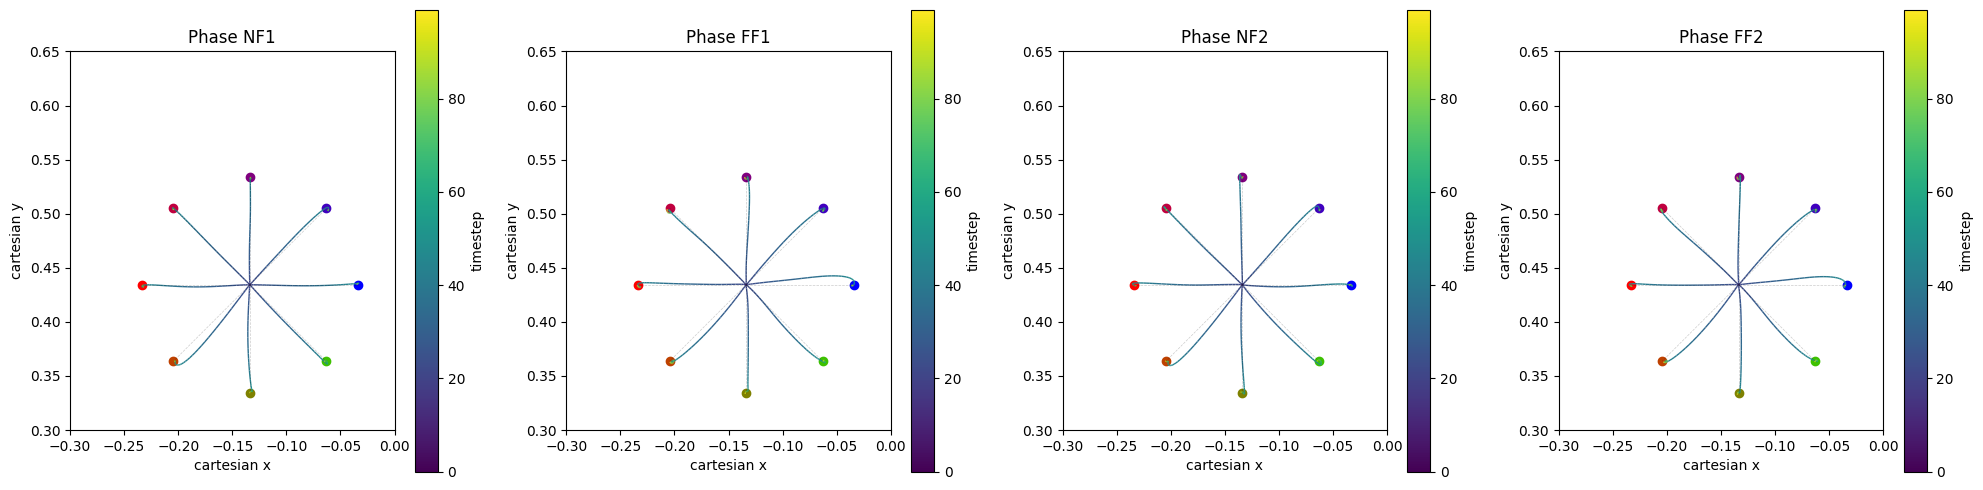

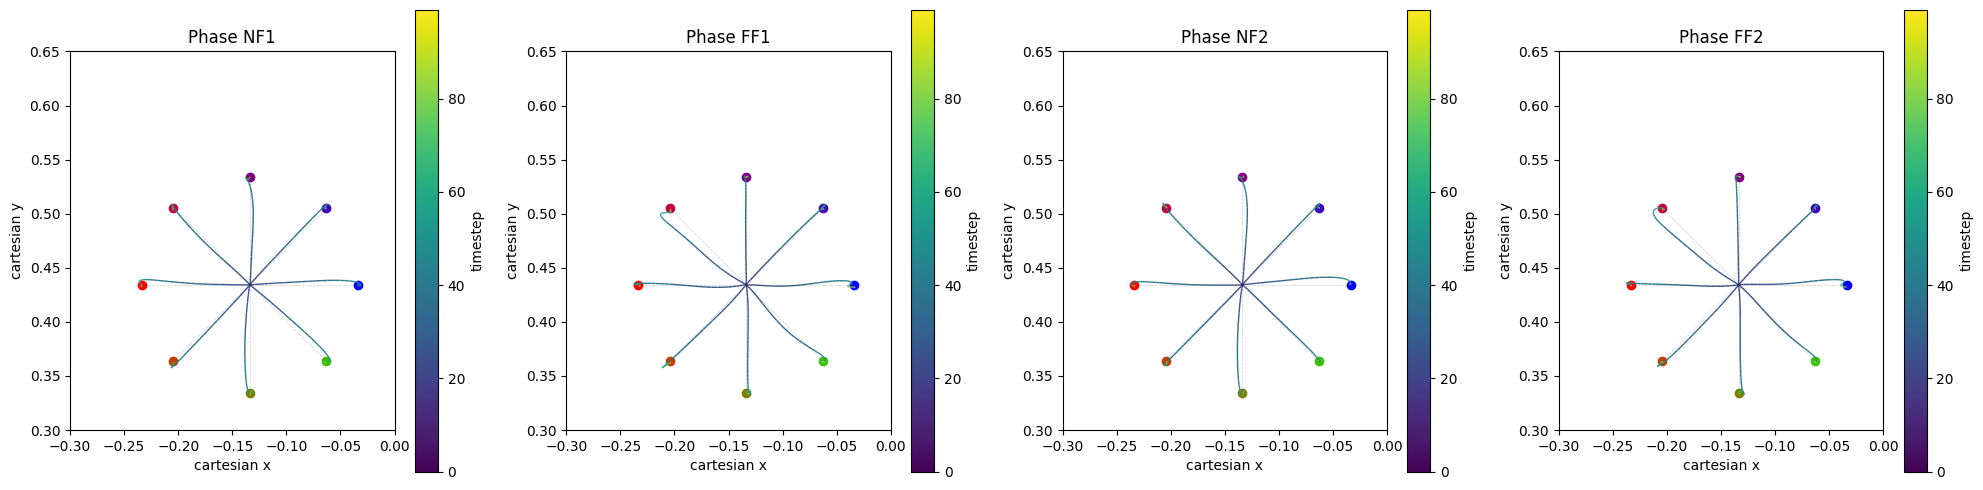

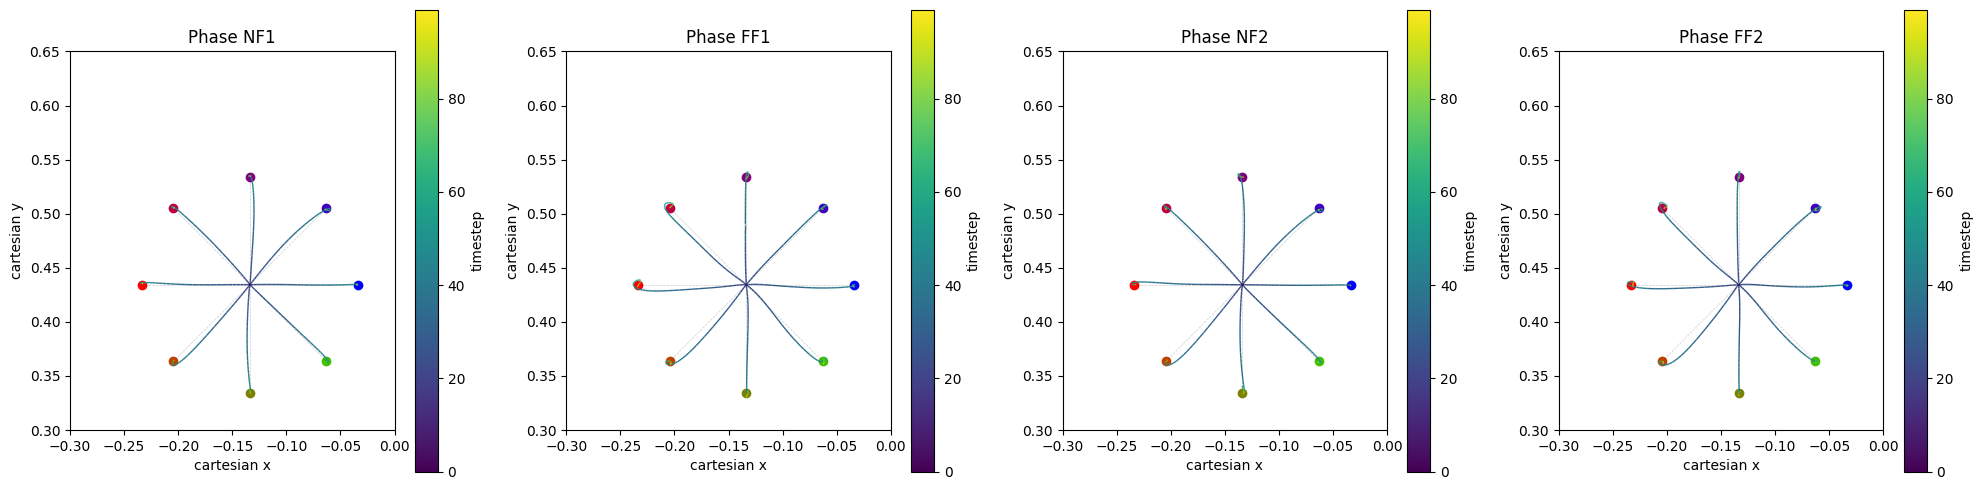

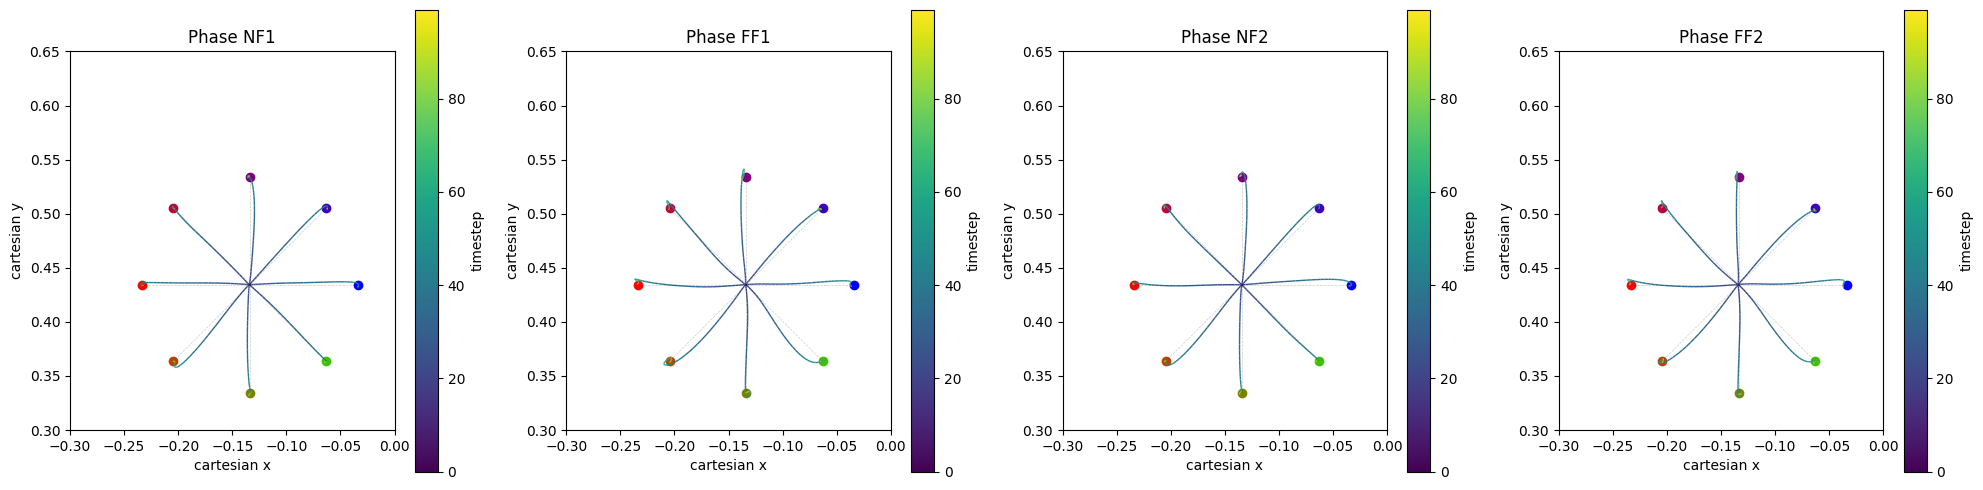

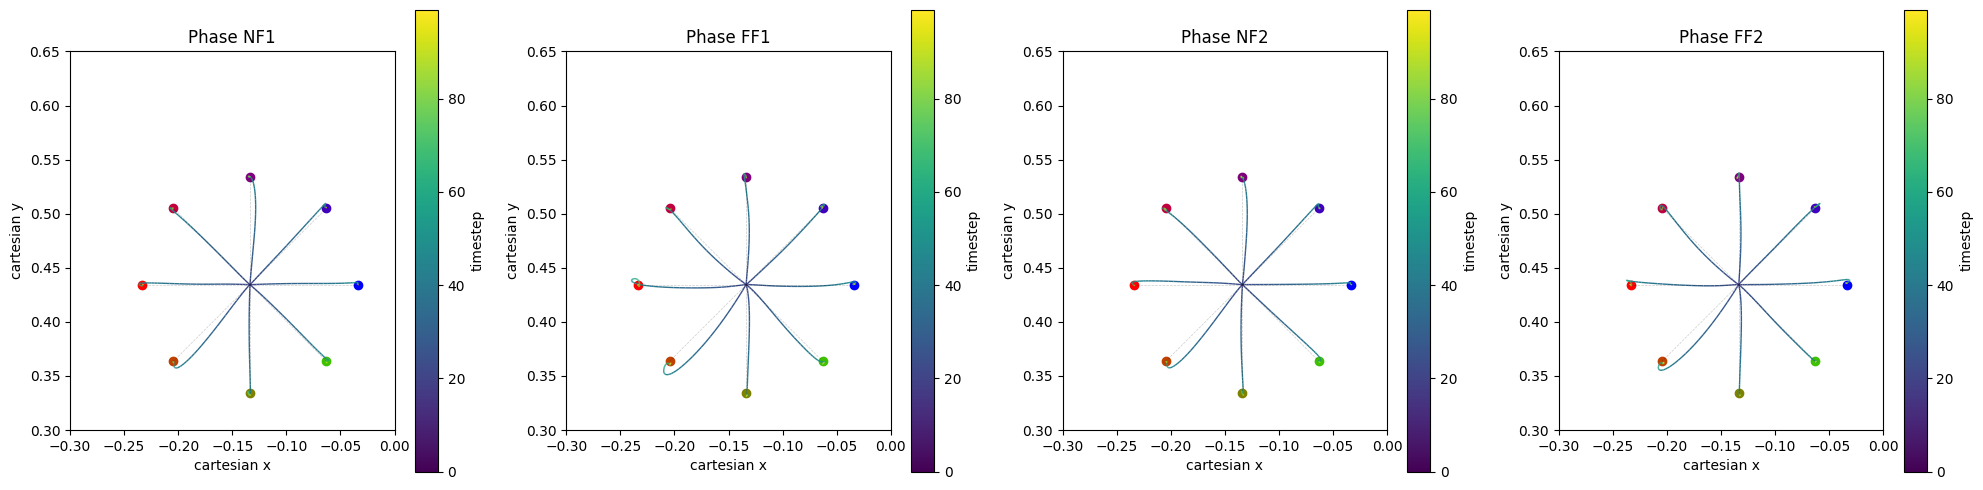

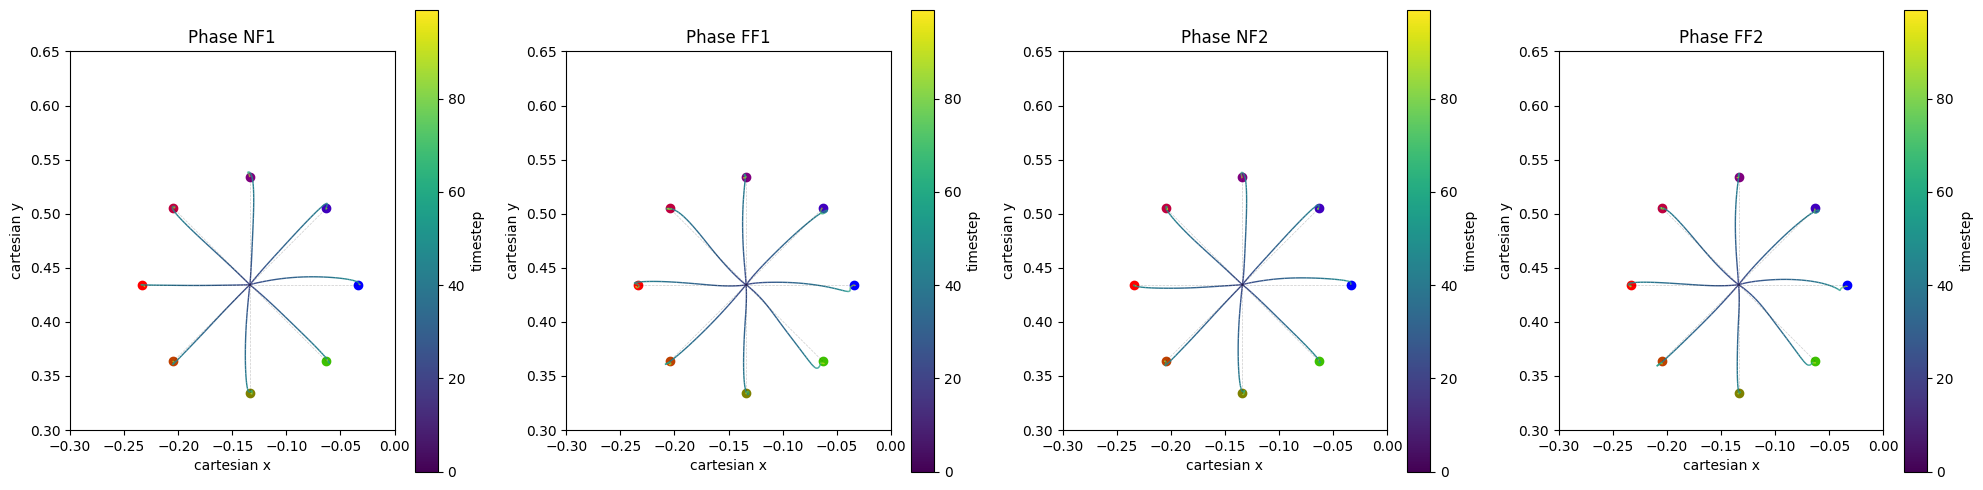

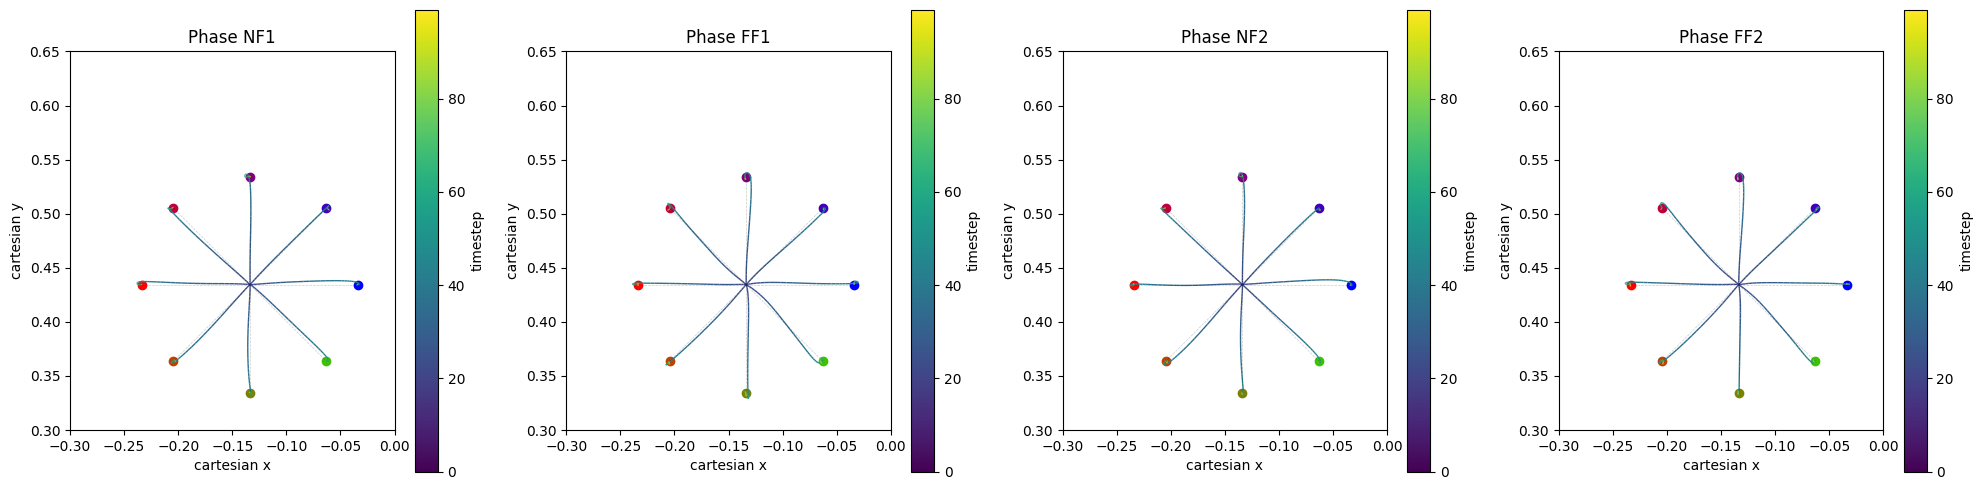

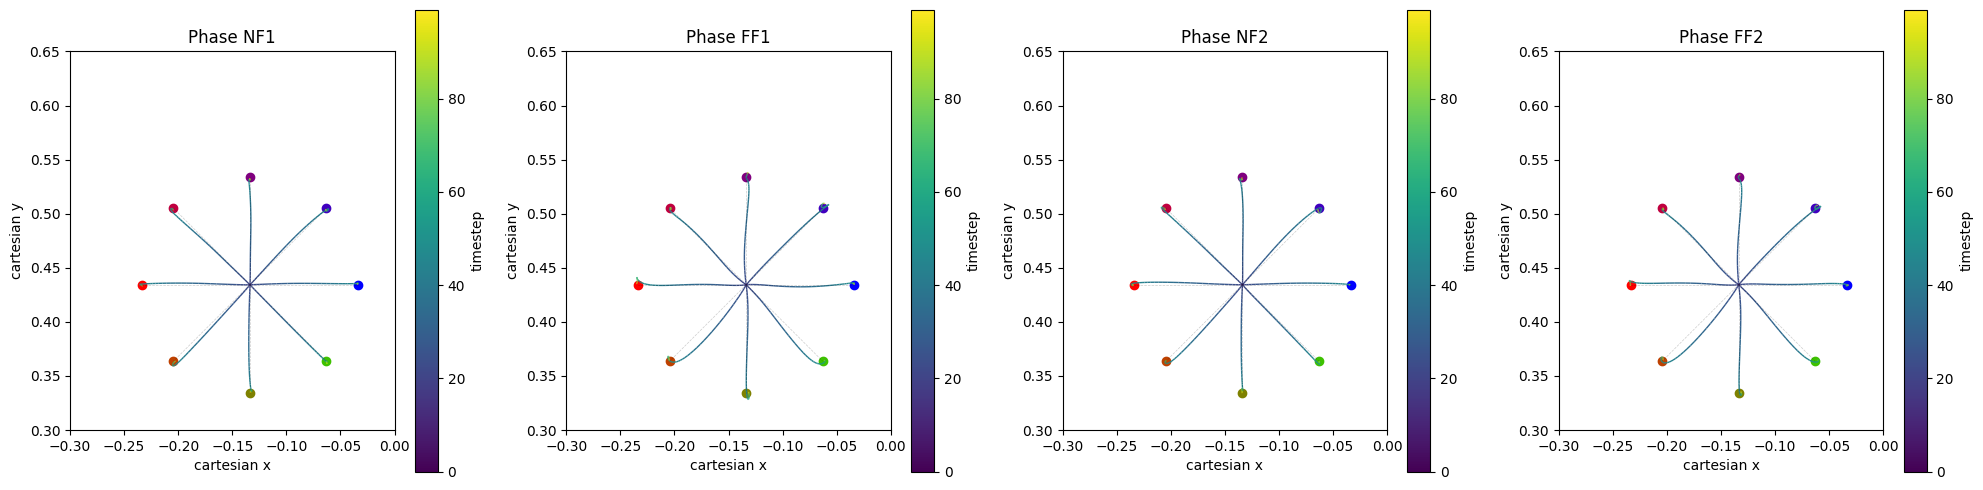

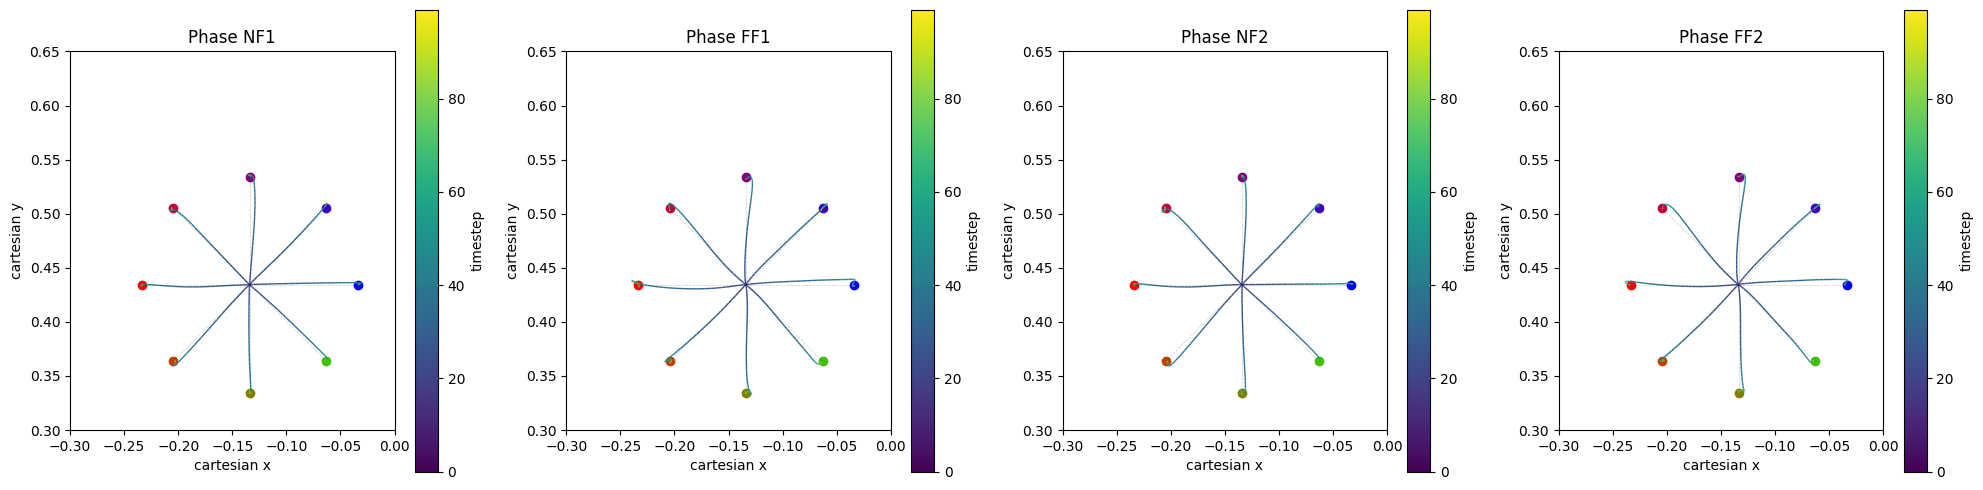

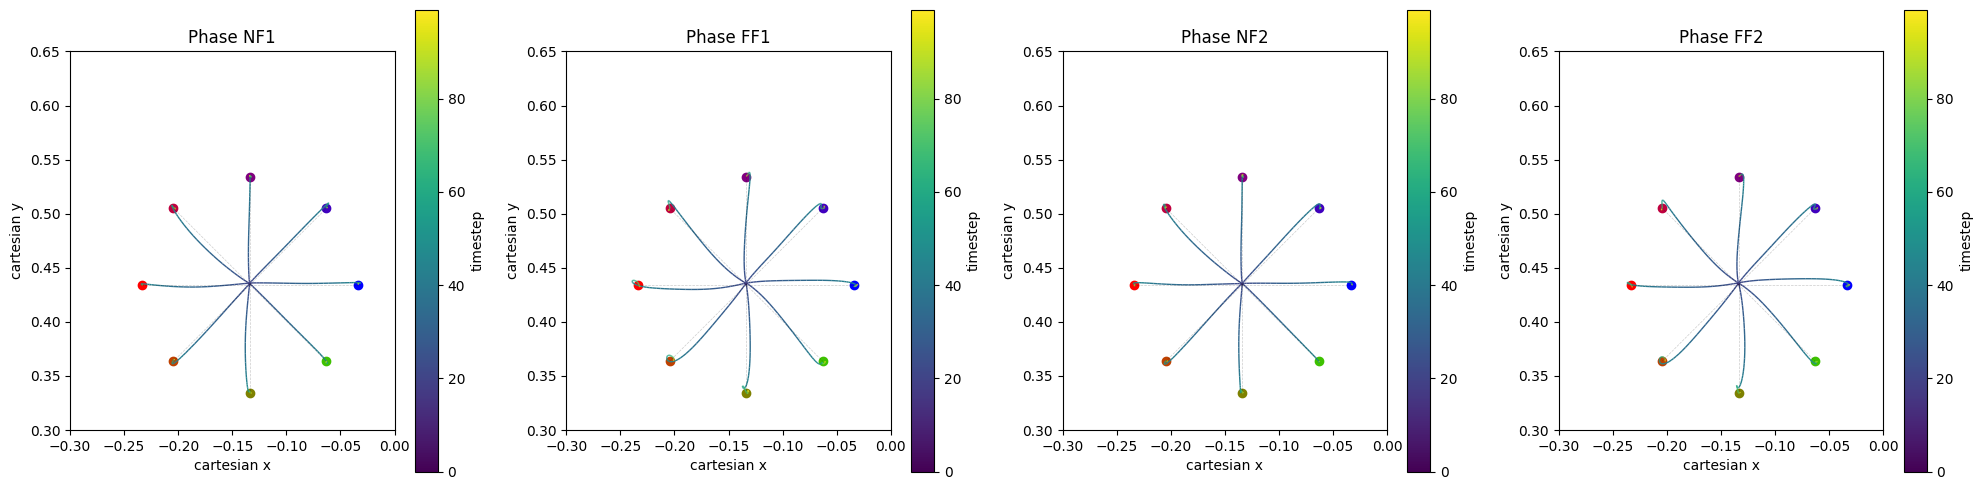

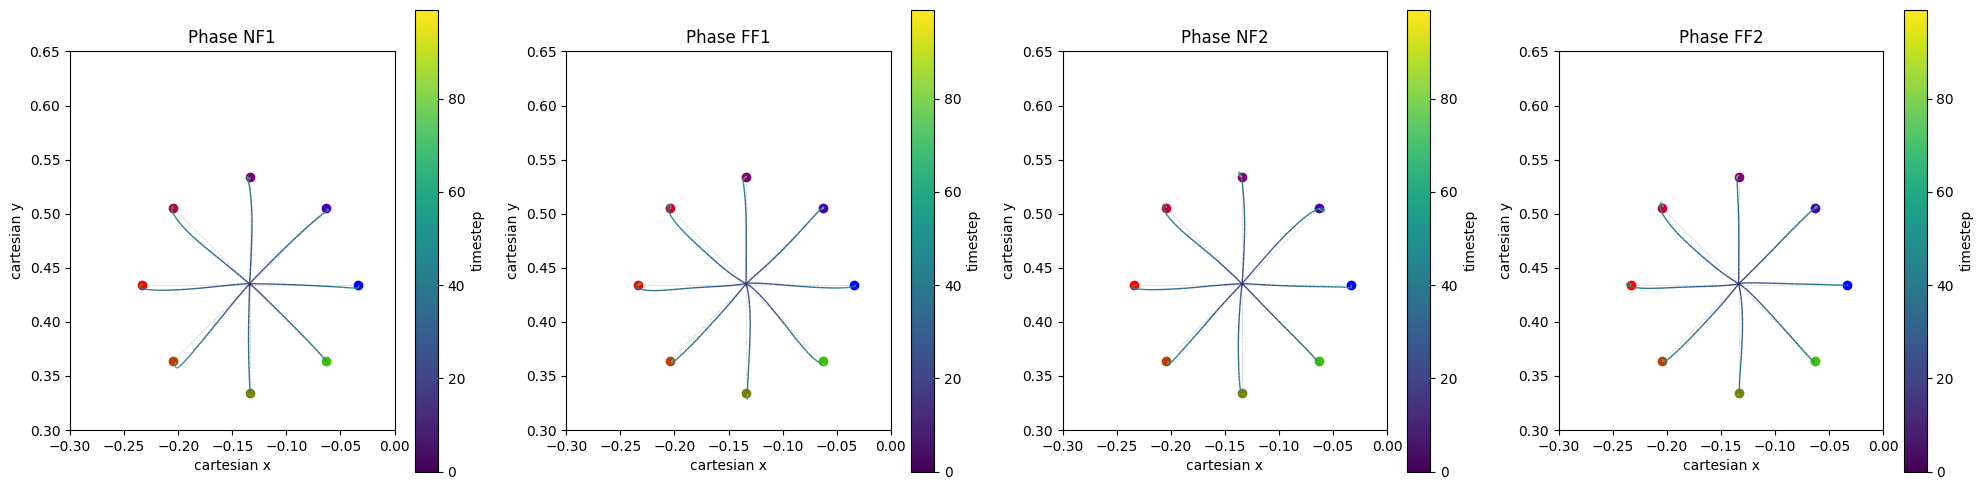

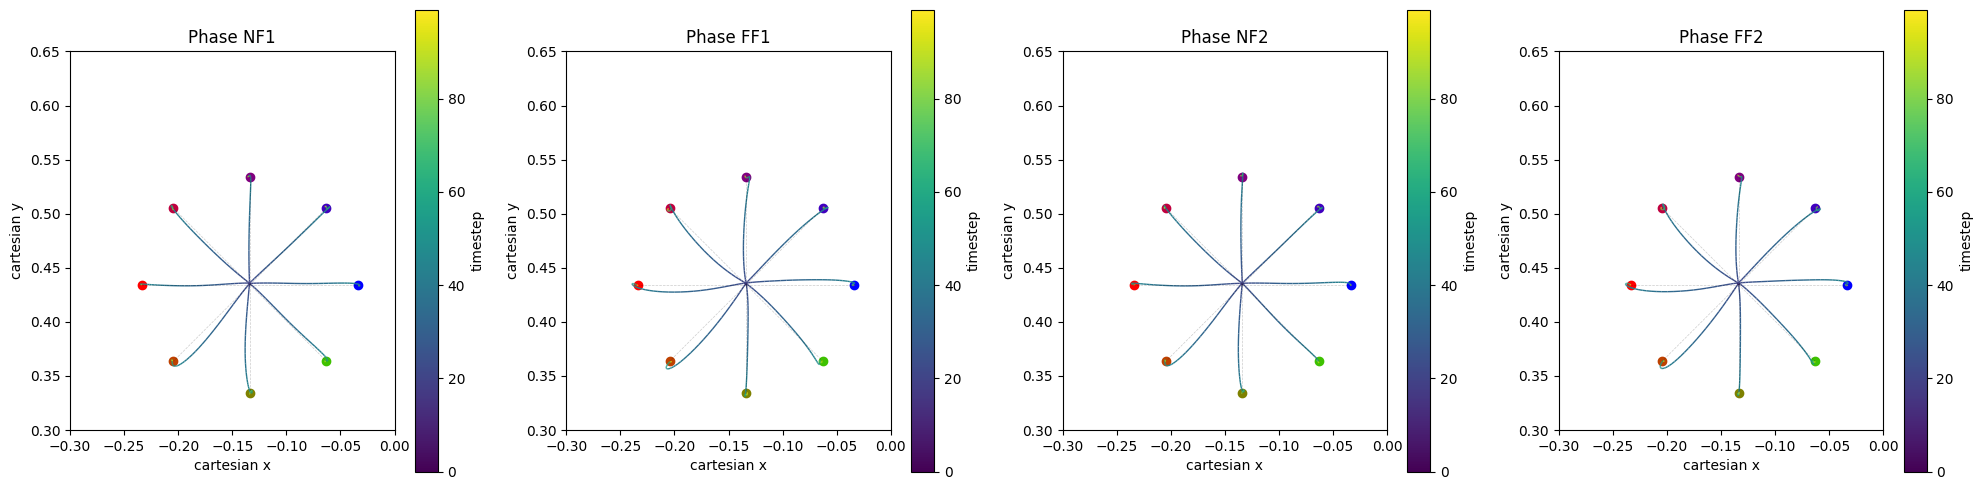

In [4]:
# Load hidden
folder_name = 'Sim_all_inv'
n_latent = 7
n_muscle = 6
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
ff_coef = [0,8,0,8]

results = pd.DataFrame()
rdms = []
#tp = np.arange(15)
tp = 15
N_idx = 15
F_idx = 24 # index of force


for mn in range(0,20):
    model_name = "model{:02d}".format(mn)

    #data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)

    data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)
    force = get_force(folder_name,model_name,phase,ff_coef)

    for i in range(len(data)):
        data[i] = data[i][:,N_idx,:]
        force[i] = force[i][:,F_idx,:]

    # remove overall mean
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)
    for i in range(len(data)):
        data[i] = data[i]-mean_N

    # use NF1 to project onto TDR axes
    X = force[0] # NF1 force 
    N = data[0] # NF1 hidden activity

    X = np.hstack((X,np.ones((X.shape[0],1))))
    beta_b2n = np.linalg.pinv(X) @ N

    # Compute the TDR axes.
    beta_n2b = np.linalg.pinv(beta_b2n)
    beta_n2b = beta_n2b[:,:2]

    # Orthogonalize the TDR axes before projection.
    beta_n2b_orth = gsog(beta_n2b)[0]

    # uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0)
    us = us.reshape(-1,1)
    us_orth = us - np.dot(beta_n2b_orth[:,0],us)/np.linalg.norm(beta_n2b_orth[:,0])**2 * beta_n2b_orth[:,0][:,None]
    us_orth = us_orth - np.dot(beta_n2b_orth[:,1],us_orth)/np.linalg.norm(beta_n2b_orth[:,1])**2 * beta_n2b_orth[:,1][:,None]

    #d_h = th.from_numpy(us_orth.T*-1)
    d_h = th.from_numpy(np.zeros_like(us_orth.T))

    data = get_data(folder_name,model_name,phase,ff_coef,is_channel=False,
                    disturb_hidden=True,t_disturb_hidden=0.15,d_hidden=d_h)

    n_phase = len(phase)
    fig,ax = plt.subplots(1,n_phase,figsize=(5*n_phase,5))
    if len(phase) == 1:
        ax = [ax]
    for i,p in enumerate(phase.keys()):
        plot.plot_simulations(ax[i],xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
        ax[i].set_title(f'Phase {p}')
    plt.tight_layout()
    plt.show()
